# Uncertain Rosenbrock Function

In [78]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import minimize, Bounds, NonlinearConstraint

## Rosenbrock function

A more complex example is the Rosenbrock function, which is a common test problem for optimisation. It is defined as:
$$f(x,y) = (a -x)^2 + b(y - x^2)^2$$

Constraints can also be applied to the problem, to restrict the feasible region of the parameter space. These are:
$$(x - 1)^3 - y + 1 \leq 0$$
$$ x + y - 2 \leq 0$$

Text(1.05, 1.05, 'Solution')

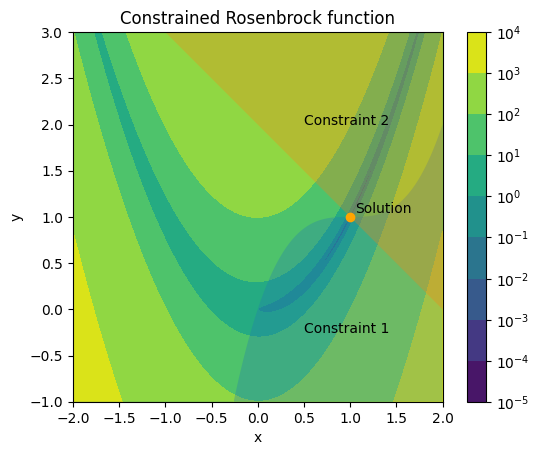

In [79]:
def rosenbrock(x: np.ndarray) -> np.ndarray:
    """Rosenbrock function.

    Parameters
    ----------
    x : np.ndarray
        Optimisation parameter vector

    Returns
    -------
    np.ndarray
        Result of Rosenbrock function
    """
    a = 1
    b = 100
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

def con1(x: np.ndarray) -> np.ndarray:
    """Value of constraint 1.

    Parameters
    ----------
    x : np.ndarray
        Optimisation parameter vector

    Returns
    -------
    np.ndarray
        Value of constraint
    """
    return (x[0] - 1) ** 3 - x[1] + 1


def con2(x: np.ndarray) -> np.ndarray:
    """Value of constraint 2.

    Parameters
    ----------
    x : np.ndarray
        Optimisation parameter vector

    Returns
    -------
    np.ndarray
        Value of constraint
    """
    return x[0] + x[1] - 2


def constraints(x: np.ndarray) -> np.ndarray:
    """Calculate values of all constraints.

    Parameters
    ----------
    x : np.ndarray
        Optimisation parameter vector

    Returns
    -------
    np.ndarray
        Values of all constraints
    """
    return np.array([con1(x), con2(x)])
    
# Now plot
# Plot solutions to constraints = 0 (changed to equalities, rearranged for y)
def con1_line(x: np.ndarray) -> np.ndarray:
    """Line for constraint 1.

    Parameters
    ----------
    x : np.ndarray
        Value of x

    Returns
    -------
    np.ndarray
        Value of y
    """
    return (x - 1) ** 3 + 1


def con2_line(x: np.ndarray) -> np.ndarray:
    """Line for constraint 2.

    Parameters
    ----------
    x : np.ndarray
        Value of x

    Returns
    -------
    np.ndarray
        Value of y
    """
    return 2 - x

N = 300
x = np.linspace(-2, 2, N)
y = np.linspace(-1, 3, N)
xx, yy = np.meshgrid(x, y)
# x_vec is vector containing x and y coordinate matrices
x_vec = np.array([xx, yy])
zz = rosenbrock(x_vec)

fig, ax = plt.subplots()
contour_set = ax.contourf(x, y, zz, locator=matplotlib.ticker.LogLocator())
ax.axis("scaled")
fig.colorbar(contour_set)
ax.set_title("Constrained Rosenbrock function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.fill_between(x=x, y1=con1_line(x), y2=y.min(), alpha=0.3)
ax.annotate("Constraint 1", (0.5, -0.25))
ax.fill_between(x=x, y1=con2_line(x), y2=y.max(), alpha=0.3)
ax.annotate("Constraint 2", (0.5, 2.0))

# Add solution point
ax.plot(1.0, 1.0, "o", color="orange")
ax.annotate("Solution", (1.05, 1.05))

## Add uncertainty

Add some epistemic uncertainty to a constraint. The uncertainty is not in a design parameter (e.g. $x$ or $y$), but in a third variable, $e_1$, which affects the cubic constraint, which becomes:

$$(x - 1)^3 - y + 1 + e_1 \leq 0$$

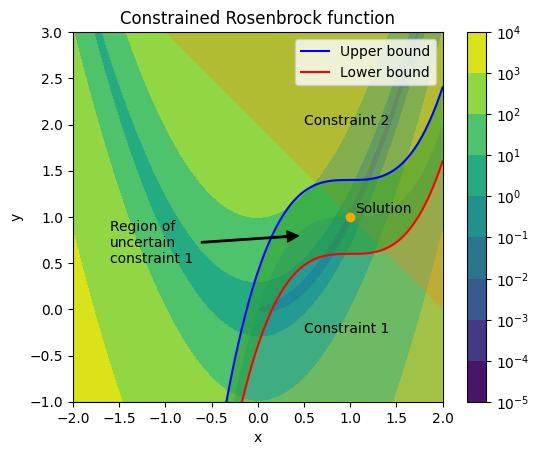

In [80]:
# con1_line with uncertainty addition
def con1_line_unc(x: np.ndarray, e: np.ndarray) -> np.ndarray:
    """Line for constraint 1.

    Parameters
    ----------
    x : np.ndarray
        Value of x
    e : np.ndarray
        Epistemic uncertainties


    Returns
    -------
    np.ndarray
        Value of y
    """
    return (x - 1) ** 3 + 1 + e[0]

# con1 with uncertainty addition
def con1_unc(x: np.ndarray, e: np.ndarray) -> np.ndarray:
    """Value of constraint 1.

    Parameters
    ----------
    x : np.ndarray
        Optimisation parameter vector
    e : np.ndarray
        Epistemic uncertainties

    Returns
    -------
    np.ndarray
        Value of constraint
    """
    return (x[0] - 1) ** 3 - x[1] + 1 + e[0]

def constraints_unc(x: np.ndarray, e: np.ndarray) -> np.ndarray:
    """Calculate values of all constraints.

    Parameters
    ----------
    x : np.ndarray
        Optimisation parameter vector
    e : np.ndarray
        Epistemic uncertainties

    Returns
    -------
    np.ndarray
        Values of all constraints
    """
    return np.array([con1_unc(x, e), con2(x)])

# Define epistemic uncertainty
unc = np.array([0.4])

# Apply bounds of uncertainty to constraint
con1_line_val_u = con1_line_unc(x, unc)
con1_line_val_l = con1_line_unc(x, -unc)

ax.plot(x, con1_line_val_u, "b", label="Upper bound")
ax.plot(x, con1_line_val_l, "r", label="Lower bound")
ax.fill_between(x=x, y1=con1_line_val_l, y2=con1_line_val_u, alpha=0.5)
ax.annotate("Region of\nuncertain\nconstraint 1", xy=(0.5, 0.8), xytext=(-1.6, 0.5), arrowprops=dict(facecolor='black', width=1, headwidth = 8, headlength = 8, shrink=0.05))
ax.legend()

fig

## Optimisation Under Uncertainty (OUU)

What is the new solution under uncertainty? Clearly the original solution will be infeasible for some of the uncertain values affecting constraint 1.

For RBDO, an outer optimisation loop optimises for an objective function representing a figure of merit (e.g. major radius) and the reliability together, whilst the inner loop performs a reliability analysis for the particular point. Reliability analysis will be focussed on first. To interpret this reliability, it is useful to visualise the constraints first.

# Visualising constraint space

Visualising globally, then locally. 

Reliability (inner loop) methods operate on the sum of the constraints. They estimate statistics based on the value of this sum locally and globally: therefore it's helpful to be able to visualise the constraint space for a simple case to understand the results of these reliability studies.

## Global constraint space
Visualise the constraint sum for each point in the optimisation parameter space. This is the global constraint response (for certain constraints).

Text(1.05, 1.05, 'Solution')

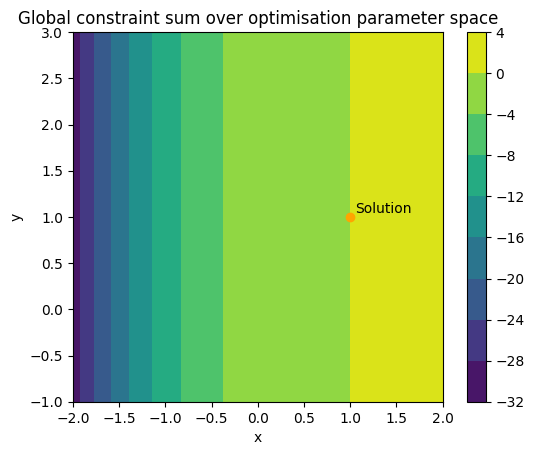

In [81]:
def constraint_sum(x: np.ndarray) -> np.ndarray:
    # Find value of each constraint at each coordinate point
    cons = constraints(x)
    # Return sum of constraints at each point
    return np.sum(cons, axis=0)

con_sum = constraint_sum(x_vec)

fig, ax = plt.subplots()
contour_set = ax.contourf(x, y, con_sum)
ax.axis("scaled")
fig.colorbar(contour_set)
ax.set_title("Global constraint sum over optimisation parameter space")
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.fill_between(x=x, y1=con1_line(x), y2=y.min(), alpha=0.3)
# ax.annotate("Constraint 1", (0.5, -0.25))
# ax.fill_between(x=x, y1=con2_line(x), y2=y.max(), alpha=0.3)
# ax.annotate("Constraint 2", (0.5, 2.0))

# Add solution point
ax.plot(1.0, 1.0, "o", color="orange")
ax.annotate("Solution", (1.05, 1.05))

The sum of the constraints only varies in x as a cubic.

## Local constraint space under uncertainty
Introduce some uncertainty to the constraints, then visualise the local uncertain constraint space (at a given point, i.e. the solution) under uncertainty.

/tmp/ipykernel_110603/3933352966.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([con1_unc(x, e), con2(x)])


Text(0.02, 0.02, 'Solution')

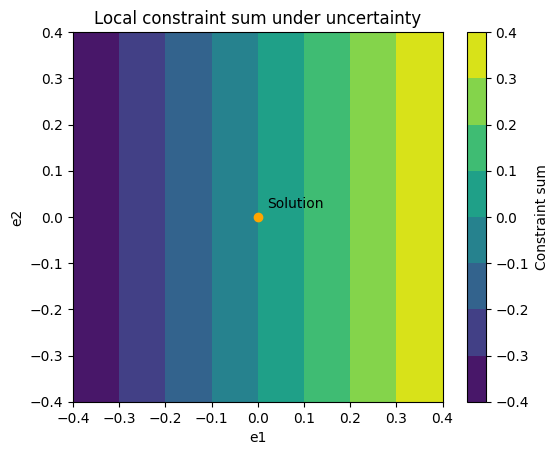

In [82]:
def constraint_sum_unc(x: np.ndarray, e: np.ndarray) -> np.ndarray:
    # Find value of each constraint at each coordinate point
    cons = constraints_unc(x, e)
    # Return sum of constraints at each point
    return np.sum(cons, axis=0)

# Define uncertainty space
e1_space = np.linspace(-unc[0], unc[0], N)
e2_space = np.linspace(-unc[0], unc[0], N)
e1_mesh, e2_mesh = np.meshgrid(e1_space, e2_space)
# unc_vec is vector containing e1 and e2 coordinate matrices
unc_vec = np.array([e1_mesh, e2_mesh])
# Local point (solution) to evaluate uncertain constraints at
sol_point = [1.0, 1.0]
con_sum_unc = constraint_sum_unc(sol_point, unc_vec)

fig, ax = plt.subplots()
contour_set = ax.contourf(e1_space, e2_space, con_sum_unc)
ax.axis("scaled")
fig.colorbar(contour_set, label="Constraint sum")
ax.set_title("Local constraint sum under uncertainty") 
ax.set_xlabel("e1")
ax.set_ylabel("e2")
# ax.fill_between(x=x, y1=con1_line(x), y2=y.min(), alpha=0.3)
# ax.annotate("Constraint 1", (0.5, -0.25))
# ax.fill_between(x=x, y1=con2_line(x), y2=y.max(), alpha=0.3)
# ax.annotate("Constraint 2", (0.5, 2.0))

# Add solution point
ax.plot(0.0, 0.0, "o", color="orange")
ax.annotate("Solution", (0.02, 0.02))

The local sum of the uncertain constraints only varies linearly in e1.